In [1]:
import os
import sys
import time
nb_dir = os.path.split(os.getcwd())[0]

sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import copy

In [3]:
from services.xml_document_info import (get_xml_info, get_xml_image_info)
from services.get_xml import  create_pdf_processing_paths, extract_pdf_metadata, process_input_pdf
from anuvaad_auditor.loghandler import log_info
from anuvaad_auditor.loghandler import log_error
from src.services import main
from src.services.get_underline import get_underline
from services import get_xml
from src.services.child_text_unify_to_parent import ChildTextUnify
from services.preprocess import prepocess_pdf_regions
from services.get_tables import page_num_correction , get_text_table_line_df
from src.services.ocr_text_utilities import  tesseract_ocr
import src.utilities.app_context as app_context
import config

In [4]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

In [5]:
app_context.application_context= dict({'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'})

## start of the program

In [6]:
'''
  folder structure of test data goes like this
  - notebooks
      - sample-data
          - input
          - output
          
  the pdfs are present in "input" directory and they are *.pdf is added into .gitignore
  just to save repo size.
'''

base_dir   = os.getcwd()
input_dir  = os.path.join(base_dir, 'sample-data','input')
save_dir   = os.path.join(base_dir, 'sample-data', 'bbox_output')
output_dir = os.path.join(base_dir, 'sample-data', 'output')

filename   = 'ncert.pdf'
lang ='hi'
index = 0

## extract the pdf into xml & background images for downstream processing

In [7]:
pdf_filepath      = os.path.join(input_dir, filename)

img_dfs,xml_dfs, page_width, page_height,working_dir, pdf_bg_img_filepaths, pdf_image_paths  = get_xml.process_input_pdf(filename, input_dir, lang)
#img_dfs, xml_dfs, page_width, page_height, working_dir, pdf_bg_img_filepaths = get_xml.process_input_pdf(pdf_filepath, output_dir, 'JOBID_1000')
#header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)


[2020-09-15 17:52:26,274] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/ncert_1d812488-f74e-11ea-8d07-38baf82f7425
[2020-09-15 17:52:26,278] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/ncert.pdf, working_dir /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/ncert_1d812488-f74e-11ea-8d07-38baf82f7425
[2020-09-15 17:52:26,517] {loghandler.py:20} MainThread INFO in loghandler: Extracting xml of /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/ncert.pdf
[2020-09-15 17:52:26,595] {loghandler.py:20} MainThread INFO in loghandler: Extracting background images of /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor

# Draw Bounding box using dfs

In [22]:
def doc_structure_analysis(xml_dfs,img_dfs,working_dir ,lang, page_width, page_height, pdf_bg_img_filepaths,pdf_image_paths):
    
    '''
        Document structure analysis to get:
            - in_dfs
            - table_dfs
            - line_dfs
            - h_dfs
            - v_dfs
            - p_dfs
            - text_block_dfs

    '''
    log_info("document structure analysis started  ===>", app_context.application_context )

    header_region, footer_region = prepocess_pdf_regions(xml_dfs, page_height)
    text_merger = ChildTextUnify()
    
    in_dfs, table_dfs, line_dfs,bg_dfs = get_text_table_line_df(xml_dfs, img_dfs, pdf_bg_img_filepaths)
    in_dfs[0]['font_family']="times"
    in_dfs[0]['font_family_updated']="times"
    h_dfs = get_xml.get_hdfs(in_dfs, header_region, footer_region)
    
    if lang != 'en':
        h_dfs = tesseract_ocr(pdf_image_paths, page_width, page_height, h_dfs, lang)
        for h_df in h_dfs:
            h_df['children'] = None
    v_dfs                              = get_xml.get_vdfs(h_dfs)
    p_dfs                              = get_xml.get_pdfs(v_dfs)
    p_dfs , line_dfs                   = get_underline(p_dfs,line_dfs,app_context.application_context)
    
    
    if lang=='en':
        p_dfs  = text_merger.unify_child_text_blocks(p_dfs)
    
    
    log_info( "document structure analysis successfully completed", app_context.application_context )
    return in_dfs,h_dfs, v_dfs, p_dfs

In [23]:
in_dfs,h_dfs, v_dfs, p_dfs = doc_structure_analysis([xml_dfs[index]],[img_dfs[index]],working_dir, lang, page_width, page_height, [pdf_bg_img_filepaths[index]],[pdf_image_paths[index]])

[2020-09-15 17:58:48,218] {loghandler.py:20} MainThread INFO in loghandler: document structure analysis started  ===>
[2020-09-15 17:58:48,349] {loghandler.py:20} MainThread INFO in loghandler: Header Footer detection completed successfully  in time 0.12359404563903809 
[2020-09-15 17:58:48,350] {loghandler.py:20} MainThread INFO in loghandler: Footers found 38 
[2020-09-15 17:58:48,350] {loghandler.py:20} MainThread INFO in loghandler: Headers found 1
[2020-09-15 17:58:48,351] {loghandler.py:20} MainThread INFO in loghandler: TableExtractor service started


In [25]:
in_dfs[0]

xml_index  text_top  text_left  text_width  text_height  \
0           0       167        255          36           22   
1           1       193        146          15           17   
2           2       975        250          11           24   
3           3       975        261          75           24   
4           4       223        199         543           27   
5           5       248        199         310           27   
6           6       249        509           5           16   
7           7       248        514         227           27   
8           8       273        199         269           27   
9           9       298        226         516           27   
10         10       324        199         543           27   
11         11       349        199         543           27   
12         12       374        199         222           27   
13         13       399        226          78           27   
14         14       424        226         516           27   
15         15       450        199         543           27   
16         16       475        199         543           27   
17         17       500        199         322           27   
18         18       500        521          12           27   
19         19       500        534         209           27   
20         20       525        199         543           27   
21         21       550        199         543           27   
22         22       576        199         543           27   
23         23       601        199         543           27   
24         24       626        199         543           27   
25         25       651        199         394           27   
26         26       676        226         516           27   
27         27       702        199         543           27   
28         28       727        199         543           27   
29         29       752        199         543           27   
30         30       777        199         543           27   
31         31       802        199         129           27   
32         32       828        226         152           27   
33         33       828        378          12           27   
34         34       828        391         352           27   
35         35       853        199         541           27   
36         36       878        226         516           27   
37         37       903        199         543           27   
38         38       929        199         158           27   

                                                 text  font_size font_family  \
0                                             o`Qfrdk         16       times   
1                                                  18         15       times   
2                                                  3-         18       times   
3                                         rjg&rjg osQ         18       times   
4   rjg bl ckj Hkh cknyksa osQ dikV BkoqQj th osQ ...         21       times   
5          u fn[kuh Fkh] u fn[khA ij lkeus gh jde&jde         21       times   
6                                                   3         12       times   
7               osQ jax&fcjaxs brus lkjs iwQy fn[kkbZ         21       times   
8         iM+s fd yxk iwQyksa osQ ckx esa vk xbZ gw¡A         21       times   
9   cgjgky---xSaxVkWd  ls  149  fdyksehVj  dh  nwj...         21       times   
10  ?kkfV;k¡---lkjs jkLrs fgeky; dh xgure ?kkfV;k¡...         21       times   
11  vkidks¸ Mªkboj&de&xkbM ftrsu ukxsZ eq>s crk jg...         21       times   
12                    cpdkus mRlkg ls iwNus yxrh gw¡A         21       times   
13                                       pfy, rks---A         21       times   
14  txg&txg xnjk, ikbZu vkSj èkwih osQ [kwclwjr uq...         21       times   
15  igkM+h  jkLrksa  ij  vkxs  c<+us  yxs  fd  ,d ...         21       times   
16  lI+ksQn&lI+ksQn ckS¼ irkdk,¡A fdlh èot dh rjg ...         21       times   
17  ;s irkdk,¡ ftu ij ea=k fy[ks gq, FksA u

In [16]:
page_index      = 0
img_filepath    = pdf_image_paths[page_index]

in_df   = in_dfs[page_index]
h_df    = h_dfs[page_index]
v_df    = v_dfs[page_index]
p_df    = p_dfs[page_index]
#ocr_df  = ocr_dfs[page_index]

In [20]:
p_df

index xml_index text_top text_left text_width text_height  \
0     0         0      139       447          9          20   
1   NaN         3      276       411         80          21   
2     4         4      318       153        596          21   
3   NaN        27     1014       458        294          21   
4    22        28     1132        26        115          11   

                                               text font_size  \
0                                                 1        18   
1                                            CORAM:        18   
2  THE HONOURABLE  MR.JUSTICE A.D.JAGADISH CHANDIRA        18   
3                     Additional Public Prosecutor.        18   
4                           http://www.judis.nic.in        12   

                 font_family font_color  attrib font_family_updated  \
0           BAAAAA+Thorndale    #000000  HEADER           Thorndale   
1  CAAAAA+BitstreamVeraSerif    #000000     NaN  BitstreamVeraSerif   
2  DAAAAA+BitstreamVeraSerif    #000000     NaN  BitstreamVeraSerif   
3  CAAAAA+BitstreamVeraSerif    #000000     NaN  BitstreamVeraSerif   
4                  Helvetica    #000000  FOOTER           Helvetica   

  font_size_updated children avg_line_height level_0  underline  
0                18     None              20     NaN      False  
1                18     None              21     NaN      False  
2                18     None              21     NaN      False  
3                18     None              21     NaN      False  
4                12     None              11     NaN      False

In [31]:
p_df['word_coords'].values[0]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [11]:
v = pd.read_json(v_df['children'][1])
v

index  xml_index  text_top  text_left  text_width  text_height  \
2       2         22       236        108         691           24   
3       3         42       277        108         553           24   
4       4         60       379        108         650           24   
5       5         82       424        108         690           24   
6       6        100       469        108         633           24   
7       7        123       514        108         637           24   
8       8        139       558        108         641           24   
9       9        157       633        108         645           24   
10     10        175       678        108         693           24   
11     11        195       723        108         690           24   
12     12        217       768        108         691           24   
13     13        240       813        108         686           24   
14     14        262       857        108         313           24   
15     15        274       932        108         419           24   
16     16        287       986        108         691           24   
17     17        304      1031        108         646           24   

                                                 text  font_size  \
2    दिल्‍ली में कोविंड -49 से संक्रमण की स्थिति ग...         16   
3    हैं, ऐसे में मेट्रो सेवा शुरू करना और उसको सु...         16   
4    नई दिल्‍ली: देशभर में लॉकडाउन 3 मई तक लागू है...         16   
5    फैसला नहीं हुआ है लेकिन सी आईएसएफ और दिल्‍्ल्...         16   
6    दी हैं. दिल्त्ती में रोज लाखों की संख्या में ...         16   
7    सुरक्षाकर्मियों और मेट्रो स्टाफ के स्वास्थ्य ...         16   
8    गाइडलाइन जारी की है जिसे ध्यान में रखते हुए अ...         16   
9    नाम ने छापने के अनुरोध पर दिल्‍ली मेट्रो के व...         16   
10   गाइडलाइन जरूर आ गई है लेकिन आज दोपहर तक मेट्र...         16   
11   सका है. यह निर्णय दिल्‍्त्ती सरकार और केंद्र ...         16   
12   की दूरी के नियम को फालों करेंगे. इसके अलावा म...         16   
13   का नियम पालन करने को कहा जाएगा. फिल्नहात्न दि...         16   
14   निर्णय लेने में सरकार की तरफ से देरी हो रही है.'         16   
15   आरोग्य सेतु एप और फेस मास्क बने मेट्रो में एं...         16   
16   सी आईएसएफ ने गाइडलाइन जारी करते हुए कहा, 'कोव...         16   
17   मेट्रो की सेवाएं प्रतिबंधित कर दी हैं. अब भार...         16   

             font_family font_color  attrib font_family_updated  \
2   HPQHPO+PalanquinDark    #525252     NaN       PalanquinDark   
3   HPQHPO+PalanquinDark    #525252     NaN       PalanquinDark   
4   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
5   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
6   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
7   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
8   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
9   HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
10  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
11  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
12  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
13  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
14  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
15  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
16  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   
17  HPQHPO+PalanquinDark    #303030     NaN       PalanquinDark   

    font_size_updated  children  \
2                15.2       NaN   
3                15.2       NaN   
4                15.2       NaN   
5                15.2       NaN   
6                15.2       NaN   
7                15.2       NaN   
8                15.2       NaN   
9                15.2       NaN   
10               15.2       NaN   
11               15.2       NaN   
12               15.2       NaN   
13               15.2       NaN   
14               15.2       NaN   
15               15.2     

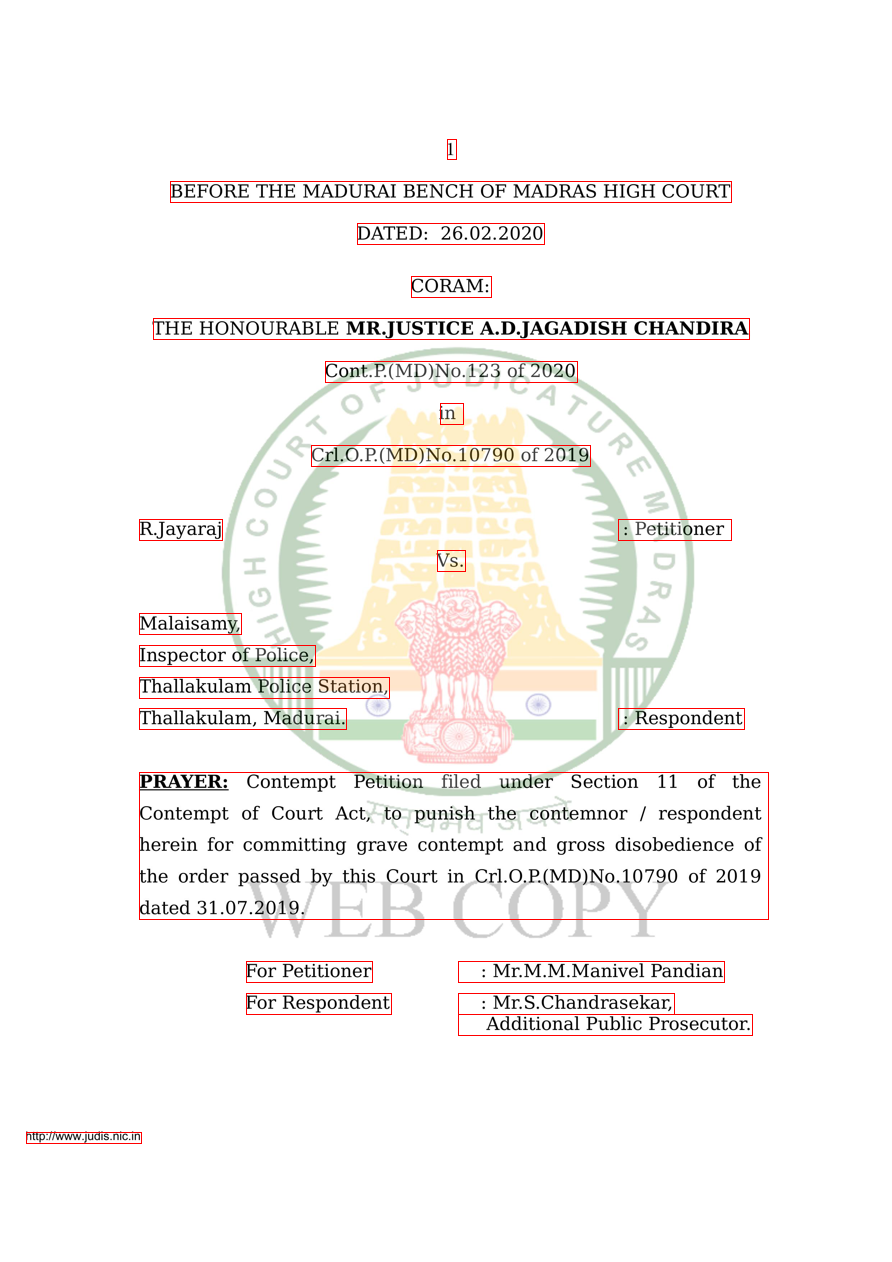

In [18]:
draw_box(img_filepath, page_width, page_height,p_df, color='red')

# Draw bounding box for json response 

In [8]:
from src.services import main

In [9]:
pdf_path = input_dir+"/"+filename
save_path  = save_dir+"/"+str(filename.split('.pdf')[0])
if not os.path.exists(save_path):
    os.system('mkdir -p {0}'.format(save_path))
data = main.DocumentStructure(app_context, filename, lang='hi',base_dir=input_dir)

[2020-09-14 19:15:28,740] {loghandler.py:48} MainThread DEBUG in loghandler: Block merger starting processing {'input': {'files': [{'locale': 'hi', 'path': 'RTIOrder_hi.pdf', 'type': 'pdf'}]}, 'jobID': 'BM-15913540488115873', 'state': 'INITIATED', 'status': 'STARTED', 'stepOrder': 0, 'workflowCode': 'abc', 'tool': 'BM', 'metadata': {'module': 'WORKFLOW-MANAGER', 'receivedAt': 15993163946431696, 'sessionID': '4M1qOZj53tIZsCoLNzP0oP', 'userID': 'd4e0b570-b72a-44e5-9110-5fdd54370a9d'}, 'taskID': 'BM-16000776881221366'}
[2020-09-14 19:15:28,742] {loghandler.py:20} MainThread INFO in loghandler: document preprocessing started ===>
[2020-09-14 19:15:28,743] {loghandler.py:20} MainThread INFO in loghandler: created processing directories successfully /home/naresh/Tarento/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/report_001_hi_8cdffdea-f690-11ea-8d07-38baf82f7425
[2020-09-14 19:15:28,744] {loghandler.py:20} MainThread INFO in loghandler: filepath /home/

KeyboardInterrupt: 

In [66]:
response = data['result']

In [67]:
def draw_bbox_image(draw,page_data):
    
    if page_data['images']:
        try:
            for image_block in page_data['images']:
                    top     = image_block["text_top"];         left   = image_block["text_left"];  
                    bottom  = top+image_block["text_height"];  right  = left+image_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='green')
            return draw
        except:
            pass

In [68]:
def draw_bbox_table(draw,page_data):
    
    if page_data['tables']:
        try:
            for table_block in page_data['tables']:
                    top     = table_block["text_top"];         left   = table_block["text_left"];  
                    bottom  = top+table_block["text_height"];  right  = left+table_block["text_width"]
                    draw.rectangle(((left, top), (right,bottom)), outline='blue')
            return draw
        except:
            pass

In [69]:
def draw_bbox_text(draw,page_data):
    
    if page_data['text_blocks']:
        try:
            for text_block in page_data['text_blocks']:
                top     = text_block["text_top"];         left   = text_block["text_left"];  
                bottom  = top+text_block["text_height"];  right  = left+text_block["text_width"]
                draw.rectangle(((left, top), (right,bottom)), outline='red')
            return draw
        except:
            pass

In [70]:
def draw_bbox_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw  = draw_bbox_text(draw,page_data)
        draw  = draw_bbox_image(draw,page_data)
        draw  = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [71]:
draw_bbox_pdf(response,pdf_image_paths,save_path)

# draw word bounding box

In [ ]:
def draw_bbox_word_pdf(data,image_files,save_path):
    for page_no in range(len(data)):
        image_path = sorted(image_files)[page_no]
        page_data = data[page_no]
        page_width = page_data['page_width']; page_height = page_data['page_height']
        image  = Image.open(image_path)
        image  = image.resize((page_width, page_height))
        draw   = ImageDraw.Draw(image)
        draw   = draw_bbox_text(draw,page_data)
        draw   = draw_bbox_image(draw,page_data)
        draw   = draw_bbox_table(draw,page_data)
        save_filepath = os.path.join(save_path,image_path.split('images/')[1])
        image.save(save_filepath)
            

In [ ]:
draw_bbox_word_pdf(response,pdf_image_paths,save_path)